# Segmentation via HLDS

For eye-blinking detection, we really just need to identify the existence of alpha-waves.

## Functions

### Import Dependencies

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import soundfile as sf
import csv
import os
import gc
import time as tick
from scipy.signal import firwin, freqz
import matplotlib.pyplot as plt

### NLMS Calculations

In [16]:
def apply_nlms_filter(x_in, w_lms_k, y_noisy, mu=None, eps=None):
    """
    Applies the NLMS filter to the input signal x_in.

    x_in: input signal (M x 1)
    w_lms_k: filter weights at time k (M x 1)
    y_noisy: noisy output signal (scalar)
    mu: learning rate
    eps: regularization parameter
    """
    if mu is None:
        raise ValueError("mu must be specified.")
    if eps is None:
        raise ValueError("eps must be specified.")
        
    y_hat = np.dot(w_lms_k, x_in)
    e = y_noisy - y_hat
    x_pow  = np.dot(x_in, x_in)
    mu_eff = mu / (x_pow + eps)
    w_lms_k1 = w_lms_k + mu_eff * e * x_in

    return y_hat, w_lms_k1, mu_eff, e
def nlms_filter_full(x_in, d, M, mu, eps=1e-15):
    """
    Basic NLMS for system ID. Returns final filter after N updates.
    """
    N = len(d)
    x_eff = np.pad(x_in, (M, 0), mode='constant')
    x_eff = x_eff[:-1]
    y_hat = np.zeros(N)
    w_hist = np.zeros((N, M))
    mu_eff_hist = np.zeros(N)
    e_hist = np.zeros(N)
    for n in range(N):
        #print(f"Processing sample {n+1}/{N}...")
        x_vec = x_eff[n:n+M]
        y_hat[n], w_hist[n], mu_eff_hist[n], e_hist[n] = apply_nlms_filter(x_vec, w_hist[n-1], d[n], mu, eps)
        
    return w_hist, y_hat, mu_eff_hist, e_hist

### Static Non-Linearities

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_derivative(x):
    # Assumes x has already been passed through sigmoid.
    return x * (1 - x)

### Hierarchical Linear Dynamical Systems

In [18]:
def learn_hlds(y, X_est, P, F_joint, Q, H_joint, R, theta, P_theta, phi):
    """
    Perform one dual-estimation update step of the HLDS.
    
    This function updates both the joint state estimate and the parameter
    estimate (theta) using the innovation from the standard HLDS update.
    
    Args:
        y: Measurement vector (array-like; shape (m,) or column vector)
        X_est: Current joint state estimate (column vector of shape (s+k+n, 1))
        P: Current estimation covariance matrix for the joint state
        F_joint: Joint state transition matrix (s+k+n x s+k+n)
        Q: Process noise covariance matrix for the joint state
        H_joint: Joint observation matrix (m x s+k+n) [typically [0,...,H]]
        R: Measurement noise covariance matrix for the state update (m x m)
        theta: Current parameter estimate (vector, e.g., shape (d,1))
        P_theta: Current parameter covariance matrix (d x d)
        phi: Regressor vector (column vector, shape (d,1)) for the parameter update.
        
    Returns:
        X_est_new: Updated joint state estimate (column vector)
        P_new: Updated joint state covariance matrix
        theta_new: Updated parameter estimate (vector)
        P_theta_new: Updated parameter covariance matrix
    """
    # Ensure y is a column vector.
    y = np.array(y).reshape((-1, 1))
    
    # -- Joint State Update (Kalman filter recursion) --
    X_pred = F_joint @ X_est
    P_pred = F_joint @ P @ F_joint.T + Q
    
    S = H_joint @ P_pred @ H_joint.T + R      # Innovation covariance
    K = P_pred @ H_joint.T @ np.linalg.inv(S)   # Kalman gain for state update
    innovation = y - (H_joint @ X_pred)         # Measurement innovation
    
    X_est_new = X_pred + K @ innovation
    P_new = (np.eye(P.shape[0]) - K @ H_joint) @ P_pred
    
    # -- Parameter Update (Dual Estimation) --
    # We assume a linear model for the parameter update:
    #      y_param = phi^T * theta + noise, 
    # and use the aggregated innovation as the measurement error.
    R_theta = 0.5  # Parameter measurement noise variance (tunable)
    S_theta = phi.T @ P_theta @ phi + R_theta    # Innovation covariance for parameters (scalar)
    K_theta = (P_theta @ phi) / S_theta            # Kalman gain for parameter update
    
    # Use the mean of the innovation as the scalar error value.
    error_scalar = np.mean(innovation)
    theta_new = theta + K_theta * error_scalar
    
    # Normalize theta (enforce unit norm) to avoid degenerate solutions.
    norm_val = np.linalg.norm(theta_new)
    if norm_val > 0:
        theta_new = theta_new / norm_val
    
    # Standard parameter covariance update.
    P_theta_new = P_theta - (K_theta @ phi.T) @ P_theta
    
    return X_est_new, P_new, theta_new, P_theta_new
def simulation_hlds(y_signal, X_est, P, F_joint, Q, H_joint, R, s, k, n, theta, P_theta, phi_func):
    """
    Simulate the HLDS dual estimation update over a sequence of measurements.
    
    For every measurement in y_signal (array of shape (T, m)), this
    function applies the dual estimation update via learn_hlds(), extracts the
    layer-specific state estimates, and records the parameter trajectory.
    
    Args:
        y_signal: Array of measurements over time (T x m)
        X_est: Initial joint state estimate (column vector of shape (s+k+n, 1))
        P: Initial joint state covariance matrix (s+k+n x s+k+n)
        F_joint: Joint state transition matrix (s+k+n x s+k+n)
        Q: Process noise covariance matrix
        H_joint: Joint observation matrix (m x s+k+n)
        R: Measurement noise covariance matrix
        s: Dimension of highest layer state (z)
        k: Dimension of middle layer state (u)
        n: Dimension of lowest layer state (x)
        theta: Initial parameter estimate for dual estimation (vector, e.g., shape (d,1))
        P_theta: Initial parameter covariance matrix (d x d)
        phi_func: Function that takes the current joint state X_est and returns 
                  the regressor vector phi (column vector) for the parameter update.
    
    Returns:
        z_estimates: Array (T x s) of highest layer state estimates over time
        u_estimates: Array (T x k) of middle layer state estimates over time
        x_estimates: Array (T x n) of lowest layer state estimates over time
        theta_history: Array (T x d) of parameter estimates over time
    """
    T = y_signal.shape[0]
    z_estimates = []      # Highest layer state estimates
    u_estimates = []      # Middle layer state estimates
    x_estimates = []      # Lowest layer state estimates
    theta_history = []    # Parameter estimates
    
    for t in range(T):
        # Get the regressor vector phi based on the current joint state.
        phi = phi_func(X_est)
        
        # Perform one dual estimation update.
        X_est, P, theta, P_theta = learn_hlds(
            y_signal[t], X_est, P, F_joint, Q, H_joint, R, theta, P_theta, phi
        )
        
        theta_history.append(theta.flatten())
        
        # Extract layer-specific states from the joint state.
        z_est = X_est[0:s]             # Highest layer state (z)
        u_est = X_est[s:s+k]           # Middle layer state (u)
        x_est = X_est[s+k:s+k+n]        # Lowest layer state (x)
        
        z_estimates.append(z_est.flatten())
        u_estimates.append(u_est.flatten())
        x_estimates.append(x_est.flatten())
        
    return (np.array(z_estimates), 
            np.array(u_estimates), 
            np.array(x_estimates), 
            np.array(theta_history))

### Convolutional Neural Network

In [19]:
def apply_cnn(x_input, w1, w2):
    """
    Apply the two-layer CNN to a single flattened input vector.
    
    Args:
        x_input: A flattened vector of shape (M*s,) from the sliding window.
        w1: Weight matrix for layer 1 of shape (h, M*s).
        w2: Weight matrix for layer 2 of shape (1, h).
        
    Returns:
        y2: The final CNN output (a scalar) as a NumPy array (shape (1,)).
        y1: The hidden-layer activation (shape (h,)).
        v1: Pre-activation of hidden layer (shape (h,)).
        v2: Pre-activation of output layer (scalar as shape (1,)).
    """
    # Layer 1: fully connected -> sigmoid
    v1 = w1 @ x_input          # shape: (h,)
    y1 = sigmoid(v1)           # shape: (h,)
    
    # Layer 2: fully connected -> sigmoid (producing a scalar)
    v2 = w2 @ y1               # shape: (1,)
    y2 = sigmoid(v2)           # shape: (1,)
    return y2, y1, v1, v2
def learn_cnn(window, desired, w1, w2, learning_rate):
    """
    Perform a single training update (one learning iteration) for the CNN on a given sliding window.
    This function replaces the inner loop content in simulation_cnn.

    Args:
        window: 2D array from HLDS outputs with shape (M, s) (a sliding window).
        desired: Desired output (target value) for the current window (scalar or shape (1,)).
        w1: Weight matrix for layer 1 of shape (h, M*s).
        w2: Weight matrix for layer 2 of shape (1, h).
        learning_rate: Scalar learning rate for weight updates.

    Returns:
        y2: The CNN's output from the forward pass (shape (1,)).
        w1: Updated weight matrix for layer 1.
        w2: Updated weight matrix for layer 2.
        error: The computed error (desired - y2) for this training instance.
    """
    # Flatten the window into a single input vector of shape (M*s,)
    x_input = window.flatten()
    #print(f"Input shape: {x_input.shape}")
    #print(f"Window shape: {window.shape}")
    
    # --- Forward Pass ---
    y2, y1, v1, v2 = apply_cnn(x_input, w1, w2)
    
    # --- Backward Pass ---
    # Compute error between desired output and CNN prediction
    error = desired - y2
    
    # Output layer delta: delta2 = error * sigmoid_derivative(y2)
    delta2 = error * sigmoid_derivative(y2)
    
    # Compute the gradient for layer 2 weights and update them
    grad_w2 = delta2 * y1              # shape: (h,)
    w2 += learning_rate * grad_w2.reshape(1, -1)
    
    # Backpropagate to compute the delta for the hidden layer
    delta1 = (w2.T * delta2).flatten() * sigmoid_derivative(y1)  # shape: (h,)
    
    # Compute the gradient for layer 1 weights and update them
    grad_w1 = np.outer(delta1, x_input)  # shape: (h, M*s)
    w1 += learning_rate * grad_w1

    return y2, w1, w2, error
def simulation_cnn(z_estimates, desire, w1, w2, learning_rate, M, s, train_index):
    """
    Run the CNN over a time sequence by sliding a window over the z_estimates,
    applying the CNN for a forward pass, computing the error with respect to desire,
    and updating the weights using backpropagation.
    
    Args:
        z_estimates: Array of HLDS outputs; shape (T, s).
        desire: Desired labels as a 1D array of length T (or shape (T,)).
        w1: Initial weight matrix for layer 1 of shape (h, M*s).
        w2: Initial weight matrix for layer 2 of shape (1, h).
        learning_rate: Learning rate (scalar).
        M: Number of delay taps (window length).
        s: Dimensionality of each z_estimate.
        
    Returns:
        y2_pred: Array of CNN outputs over time; shape (T, 1).
        w1: Final weight matrix for layer 1.
        w2: Final weight matrix for layer 2.
    """
    T = len(z_estimates)
    y2_pred = np.zeros((T, 1))
    input_dim = M * s  # flattened input dimension
    
    for i in range(M, T):
        # Extract the window: from time i-M to i, shape (M, s)
        window = z_estimates[i - M:i].reshape(M, s)
        # Flatten the window into a vector of shape (M*s,)
        if i < train_index:
            y2_pred[i], w1, w2, error = learn_cnn(window, desire[i], w1, w2, learning_rate)
        else:
            y2_pred[i], _, _, _ = apply_cnn(window.flatten(), w1, w2)

    return y2_pred, w1, w2
def simulation_cnn_inference(z_estimates, w1, w2, M, s):
    """
    Run the CNN over a time sequence in inference mode without updating the weights.
    
    Args:
        z_estimates: Array from HLDS; shape (T, s).
        w1: Trained weight matrix for layer 1 of shape (h, M*s).
        w2: Trained weight matrix for layer 2 of shape (1, h).
        M: Window length (number of delay taps).
        s: Dimensionality of each z_estimate.
        
    Returns:
        y2_pred: CNN outputs over time; shape (T, 1).
    """
    T = len(z_estimates)
    y2_pred = np.zeros((T, 1))
    input_dim = M * s

    for i in range(M, T):
        window = z_estimates[i - M:i].reshape(M, s)
        x_input = window.flatten()  # shape: (input_dim,)
        
        y2, _, _, _ = apply_cnn(x_input, w1, w2)
        y2_pred[i] = y2

    return y2_pred


### Machine Learning Pipeline Functions

In [20]:
def learn_hlds_learn_cnn_pipeline(y, X_est, P, F_joint, Q, H_joint, R, 
                                  theta, P_theta, phi, window, desired, 
                                  w1, w2, learning_rate):
    """
    HLDS + CNN learn pipeline: first update HLDS, then train the CNN for one iteration.
    
    Returns:
        Updated HLDS outputs: X_est_new, P_new, theta_new, P_theta_new
        CNN training outputs: y2 (output), updated weights w1, w2, and error.
    """
    # 1. Learn HLDS for one iteration.
    X_est_new, P_new, theta_new, P_theta_new = learn_hlds(
        y, X_est, P, F_joint, Q, H_joint, R, theta, P_theta, phi
    )
    
    # 2. Train the CNN for one iteration using the given window and desired output.
    y2, w1, w2, error = learn_cnn(window, desired, w1, w2, learning_rate)
    
    return X_est_new, P_new, theta_new, P_theta_new, y2, w1, w2, error
def learn_hlds_apply_cnn_pipeline(y, X_est, P, F_joint, Q, H_joint, R, 
                                  theta, P_theta, phi, window, w1, w2):
    """
    HLDS + CNN apply pipeline: update HLDS and use CNN for inference.
    
    Returns:
        Updated HLDS outputs: X_est_new, P_new, theta_new, P_theta_new
        CNN inference output: y2 (without training update)
    """
    # 1. Learn HLDS for one iteration.
    X_est_new, P_new, theta_new, P_theta_new = learn_hlds(
        y, X_est, P, F_joint, Q, H_joint, R, theta, P_theta, phi
    )
    
    # 2. CNN inference: flatten the window and run a forward pass.
    x_input = window.flatten()
    y2, _, _, _ = apply_cnn(x_input, w1, w2)
    
    return X_est_new, P_new, theta_new, P_theta_new, y2
# def simulation_hlds_cnn_pipeline(y_signal, desire, cutoff, X_est, P, F_joint, Q, 
#                                  H_joint, R, theta, P_theta, phi_func, w1, w2, 
#                                  learning_rate, M, s):
#     """
#     Runs the combined HLDS-CNN simulation over the measurement sequence.
    
#     For iterations < cutoff, it updates HLDS and trains the CNN.
#     For iterations >= cutoff, it updates HLDS and applies the CNN in inference mode.
    
#     The CNN input is a sliding window (length M) of the HLDS z estimates (first s rows of X_est).
    
#     Args:
#         y_signal: numpy array of shape (T, m) with the measurements.
#         desire: desired label sequence (length T).
#         cutoff: iteration index at which CNN training stops.
#         X_est, P, F_joint, Q, H_joint, R, theta, P_theta: HLDS variables.
#         phi_func: function mapping the HLDS state to the regressor phi.
#         w1, w2: CNN weights.
#         learning_rate: CNN learning rate.
#         M: sliding window length.
#         s: dimensionality of the HLDS top layer (z).
    
#     Returns:
#         Final HLDS state variables, a list of CNN outputs, and a list of HLDS z estimates.
#     """
#     T = y_signal.shape[0]
#     cnn_outputs = []
#     z_estimates = []   # to store the HLDS z (first s rows)
#     z_buffer = []      # for creating the sliding window
    
#     # Initialize the buffer with the initial HLDS z.
#     z_initial = X_est[:s].copy()
#     z_buffer.append(z_initial.flatten())
#     z_estimates.append(z_initial.flatten())
    
#     for i in range(T):
#         y = y_signal[i]          # measurement vector (shape (m,))
#         desired_val = desire[i]  # desired label for CNN training
        
#         # Build a sliding window of HLDS z estimates.
#         # If there are fewer than M samples, pad with the first available z.
#         if len(z_buffer) < M:
#             pad_length = M - len(z_buffer)
#             padded_window = np.vstack(z_buffer + [z_buffer[0]] * pad_length)
#         else:
#             padded_window = np.vstack(z_buffer[-M:])  # shape (M, s)
        
#         # Compute the current regressor phi from the HLDS state.
#         phi = phi_func(X_est)
        
#         if i < cutoff:
#             # Training phase: learn HLDS & update CNN.
#             X_est, P, theta, P_theta, cnn_out, w1, w2, _ = learn_hlds_learn_cnn_pipeline(
#                 y, X_est, P, F_joint, Q, H_joint, R, theta, P_theta, phi,
#                 padded_window, desired_val, w1, w2, learning_rate
#             )
#         else:
#             # Inference phase: learn HLDS & apply CNN.
#             X_est, P, theta, P_theta, cnn_out = learn_hlds_apply_cnn_pipeline(
#                 y, X_est, P, F_joint, Q, H_joint, R, theta, P_theta, phi,
#                 padded_window, w1, w2
#             )
        
#         # Extract the HLDS z estimate (first s rows of X_est) and store it.
#         z_new = X_est[:s].copy().flatten()
#         z_buffer.append(z_new)
#         z_estimates.append(z_new)
#         cnn_outputs.append(cnn_out.flatten()[0])
    
#     return X_est, P, theta, P_theta, cnn_outputs, z_estimates

def simulation_hlds_cnn_pipeline(y_signal, desire, cutoff, X_est, P, F_joint, Q, 
                                 H_joint, R, theta, P_theta, phi_func, w1, w2, 
                                 learning_rate, M, s):
    """
    Runs the combined HLDS-CNN simulation over the full measurement sequence.
    
    For iterations where the sliding window of HLDS z estimates is not yet full,
    only the HLDS update is performed. Once the buffer is filled (i.e. when we
    have M HLDS z estimates), the CNN is updated:
      - For iterations < cutoff, the CNN is updated via learning.
      - For iterations >= cutoff, the CNN is used only for inference.
    
    Args:
        y_signal: Array of shape (T, m) with measurements.
        desire: Array of desired labels of length T.
        cutoff: Iteration index where CNN training stops.
        X_est, P, F_joint, Q, H_joint, R, theta, P_theta: HLDS parameters.
        phi_func: Function mapping HLDS state to regressor phi.
        w1, w2: CNN weights.
        learning_rate: CNN learning rate.
        M: Sliding window length.
        s: Dimensionality of the HLDS top layer (z).
        
    Returns:
        Final HLDS state variables,
        list of CNN outputs (for iterations when CNN update was run; np.nan otherwise),
        and list of HLDS z estimates.
    """
    T = y_signal.shape[0]
    cnn_outputs = []  # To store CNN outputs (or NaN for iterations where CNN isn't updated)
    z_estimates = []  # To store HLDS z estimates (first s rows)
    z_buffer = []     # Buffer to build sliding window; initially empty.
    
    # Initially, store the initial HLDS z estimate.
    z_initial = X_est[:s].copy()
    z_buffer.append(z_initial.flatten())
    z_estimates.append(z_initial.flatten())
    
    for i in range(T):
        y = y_signal[i]         # Measurement vector.
        desired_val = desire[i] # Desired label for the CNN.
        
        phi = phi_func(X_est)   # Compute regressor from current HLDS state.
        
        # Check if the sliding window is full (requires M estimates).
        if len(z_buffer) < M:
            # Not enough samples for a full window:
            # Only update HLDS and skip CNN update.
            X_est, P, theta, P_theta = learn_hlds(
                y, X_est, P, F_joint, Q, H_joint, R, theta, P_theta, phi
            )
            # Indicate that CNN output is not computed.
            cnn_out = np.nan
        else:
            # Create the sliding window from the last M HLDS z estimates.
            window = np.vstack(z_buffer[-M:])  # shape: (M, s)
            if i < cutoff:
                # Training phase: update both HLDS and train the CNN.
                X_est, P, theta, P_theta, cnn_out, w1, w2, _ = learn_hlds_learn_cnn_pipeline(
                    y, X_est, P, F_joint, Q, H_joint, R, theta, P_theta, phi,
                    window, desired_val, w1, w2, learning_rate
                )
            else:
                # Inference phase: update HLDS and run CNN inference.
                X_est, P, theta, P_theta, cnn_out = learn_hlds_apply_cnn_pipeline(
                    y, X_est, P, F_joint, Q, H_joint, R, theta, P_theta, phi,
                    window, w1, w2
                )
                
            # Extract a scalar value from the CNN output.
            if isinstance(cnn_out, np.ndarray):
                cnn_out = cnn_out.flatten()[0]
        
        # Record the updated HLDS z estimate.
        z_new = X_est[:s].copy().flatten()
        z_buffer.append(z_new)
        z_estimates.append(z_new)
        cnn_outputs.append(cnn_out)
    
    return X_est, P, theta, P_theta, cnn_outputs, z_estimates

### Plotting

In [21]:
def plot_signals(time, x, title, num_samples=None):
    """
    Plots the first num_samples of the original input and the desired (delayed) signal.
    
    Parameters:
        y (numpy array): Original input signal.
        D (int): Delay.
        num_samples (int): Number of samples to plot.
    """
    if num_samples is None:
        num_samples = len(x)
    plt.figure(figsize=(20, 10))
    plt.plot(time[:num_samples], x[:num_samples], label='Original Input', color='blue')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_signals_comparison(time, x, d, title, num_samples=None):
    """
    Plots the first num_samples of the original input and the desired (delayed) signal.
    
    Parameters:
        y (numpy array): Original input signal.
        d (numpy array): Desired signal.
        num_samples (int): Number of samples to plot.
    """
    if num_samples is None:
        num_samples = len(x)
    plt.figure(figsize=(20, 10))
    plt.plot(time[:num_samples], x[:num_samples], label='Original Input', color='blue', linestyle='-', alpha=0.7)
    plt.plot(time[:num_samples], d[:num_samples], label='Desired Signal', color='red', linestyle='--', alpha=0.7)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_signals_stft(time, x, title, num_samples=None):
    """
    Plots the first num_samples of the original input and the desired (delayed) signal.
    
    Parameters:
        y (numpy array): Original input signal.
        D (int): Delay.
        num_samples (int): Number of samples to plot.
    """
    if num_samples is None:
        num_samples = len(x)
    plt.figure(figsize=(20, 10))
    plt.specgram(x[:num_samples], NFFT=64, Fs=1/(time[1]-time[0]), noverlap=16, cmap='viridis')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='Intensity (dB)')
    plt.show()

## Part 1

## Pre-Train the Weights Based on our Expectations
Now, for the mixture of experts, we can pre-train the weights on the first 6 instances of the audio.

In [22]:
# ================================================================
# Data pre-processing
# Uncomment if you need to fill in missing values in the CSV file
# ================================================================

# data = pd.read_csv('blink3.csv', delimiter=',')
# # Fill in missing values in the 'Label' column with 0
# data['Label'].fillna(0, inplace=True)
# # Save the modified DataFrame to a new CSV file
# data.to_csv('blink3.csv', index=False)

#### Testing New

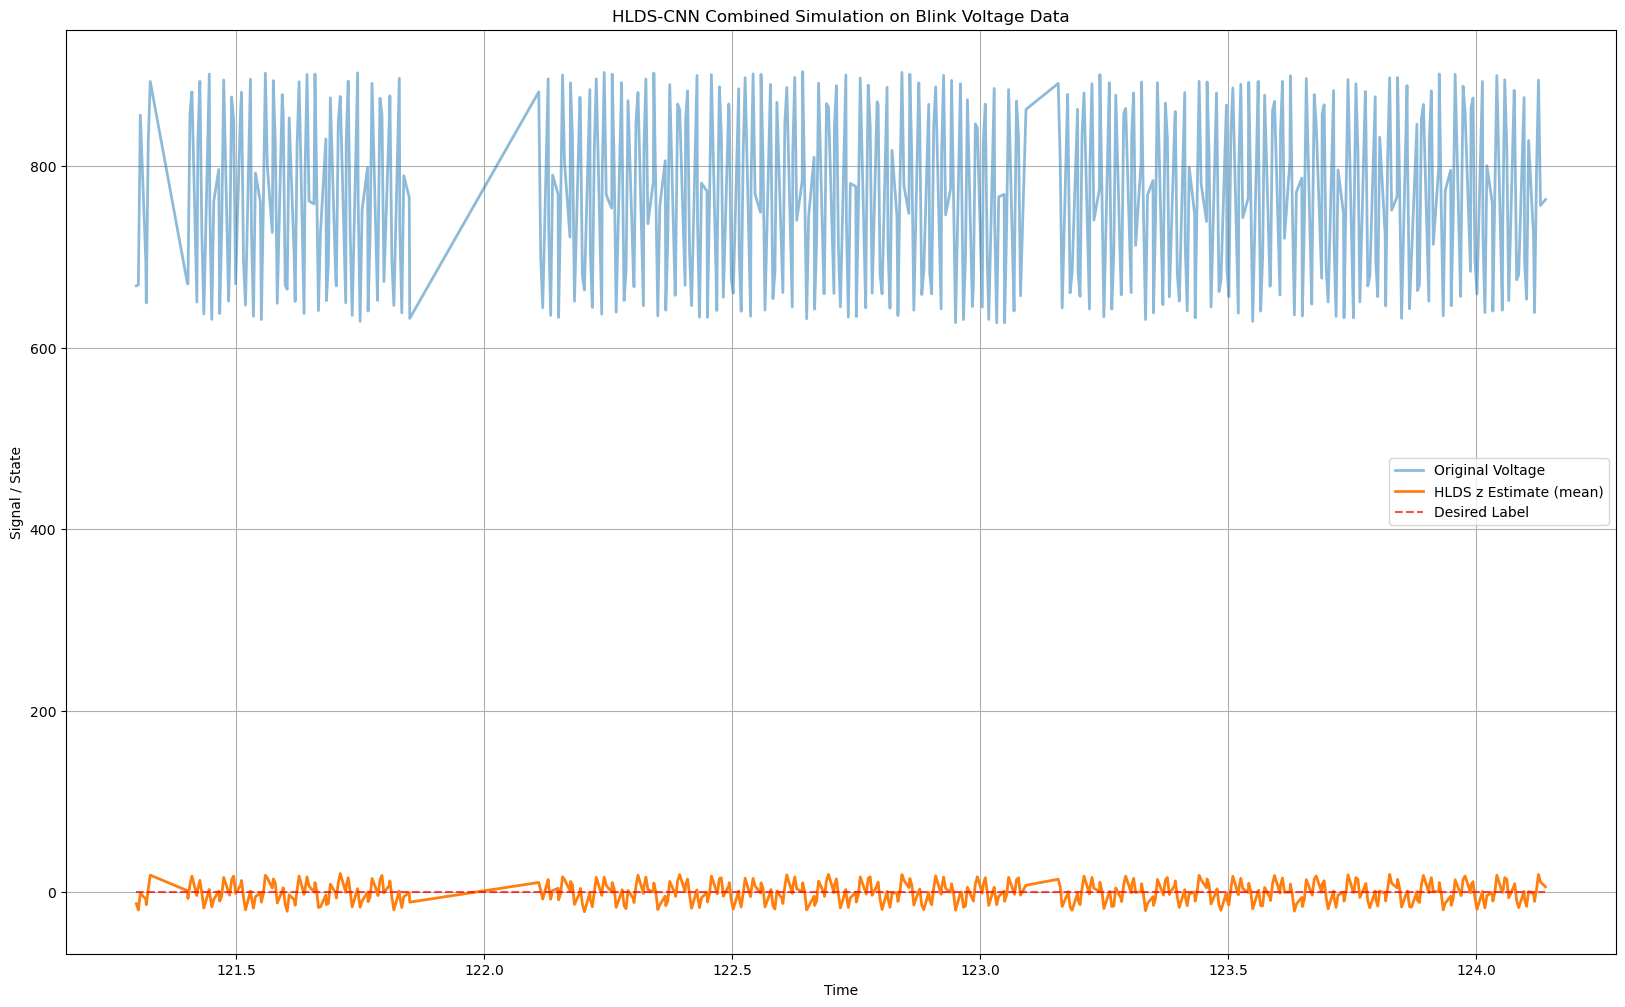

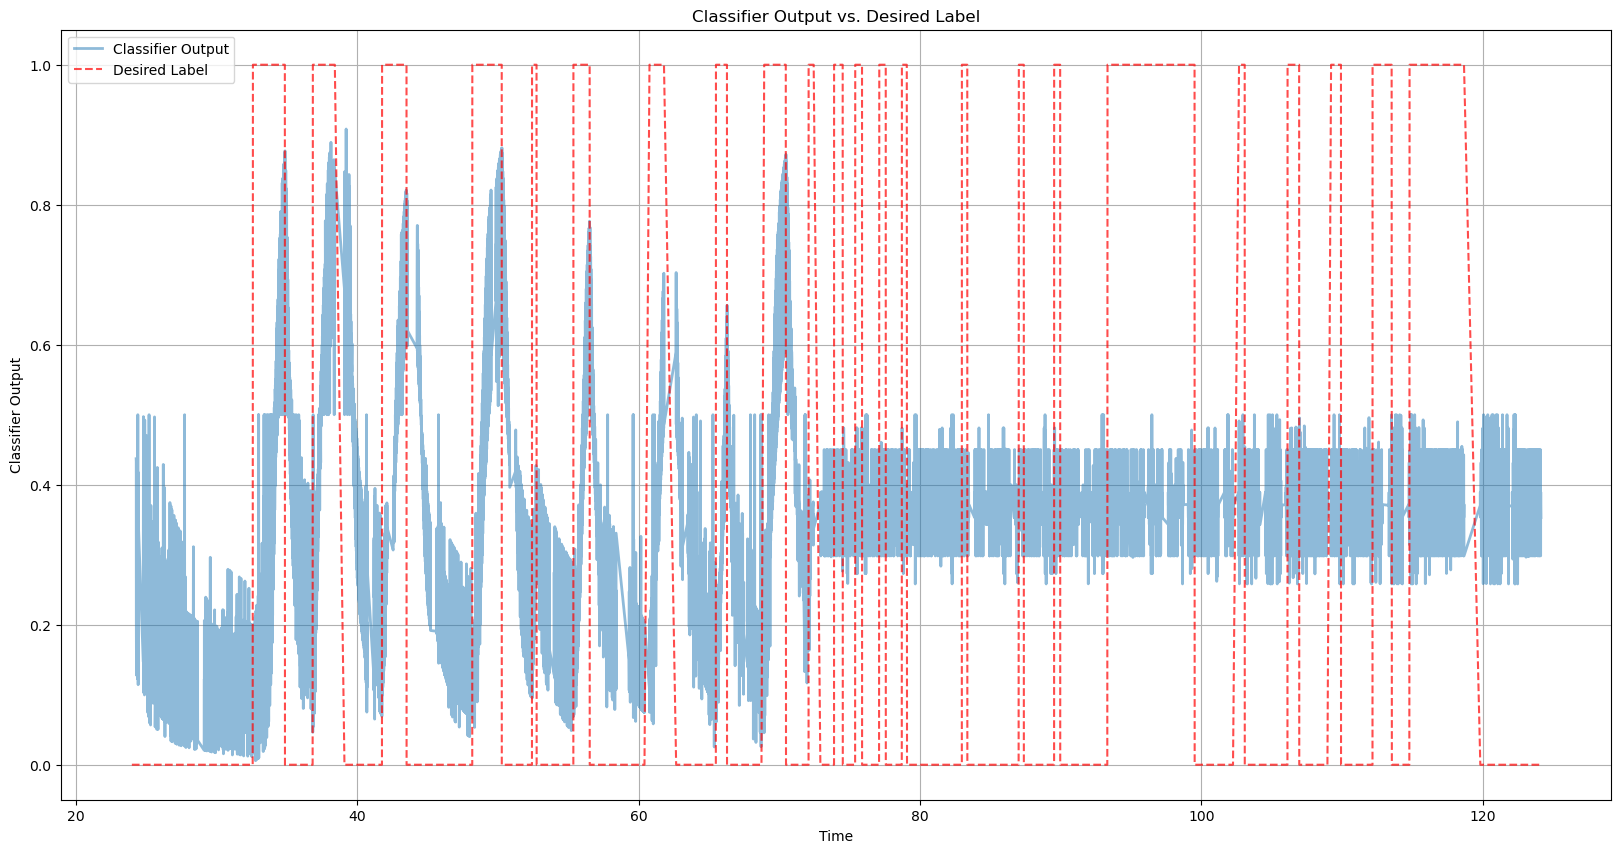

In [23]:
# === Load Data and Prepare Observation Signal ===
data = pd.read_csv('blink2.csv', delimiter=',')
data = data.drop(columns=['Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8'])
voltage = data['Ch1'].to_numpy()      # Voltage measurement (one channel)
time_axis = data['Time'].to_numpy()     # Time vector
desire = data['Label'].to_numpy()       # Desired labels

# Expand voltage to match HLDS measurement dimension.
# Here we assume m = 64.
m = 64
y_signal = np.tile(voltage.reshape(-1, 1), (1, m))  # shape (T, m)

# === Set Up HLDS Parameters ===
s = 4    # Highest layer state (z)
k = 16   # Middle layer state (u)
n = 64   # Lowest layer state (x)
state_dim = s + k + n

# Define dynamics.
F_z = np.eye(s)
G = np.eye(k)
D = 0.1 * np.random.randn(k, s)
F_layer = np.eye(n)
B = 0.1 * np.random.randn(n, k)

# Joint state transition matrix.
F_joint = np.block([
    [F_z,               np.zeros((s, k)),      np.zeros((s, n))],
    [D,                 G,                     np.zeros((k, n))],
    [np.zeros((n, s)),  B,                     F_layer]
])

# Observation matrix (extracts the lowest layer).
H = np.eye(n)  # shape (64, 64)
H_joint = np.hstack([np.zeros((m, s+k)), H])

# Noise covariances.
Q = 0.01 * np.eye(state_dim)
R = 0.5 * np.eye(m)

# Initial HLDS state and covariance.
X_est = np.zeros((state_dim, 1))
P = np.eye(state_dim)

# === Set Up Dual Estimation Variables ===
theta = np.array([[1.0]])
P_theta = np.eye(1)
# phi_func extracts a regressor from the HLDS state.
phi_func = lambda X: np.array([[np.mean(X[s+k:s+k+n])]])

# === Set Up CNN Parameters and Weights ===
M = 64           # Sliding window length (number of taps)
h = 4            # Hidden layer size
input_dim = M * s
w1 = np.random.randn(h, input_dim) / np.sqrt(input_dim)
w2 = np.random.randn(1, h) / np.sqrt(h)
learning_rate = 0.1

# === Run the Combined HLDS-CNN Simulation ===
# Specify the cutoff iteration index (for switching from CNN training to inference).
cutoff = 8000  # Adjust based on your data length and desired training phase

final_X_est, final_P, final_theta, final_P_theta, cnn_outputs, z_estimates = simulation_hlds_cnn_pipeline(
    y_signal, desire, cutoff,
    X_est, P, F_joint, Q, H_joint, R,
    theta, P_theta, phi_func, w1, w2, learning_rate, M, s
)

# === Plot HLDS (z Estimate) vs. Original Voltage and Desired Label ===
# Here we use the mean value of the HLDS z estimates (each of dimension s) as a representative signal.
z_estimates = np.array(z_estimates)  # shape (T+1, s)
z_mean = np.mean(z_estimates, axis=1)

plt.figure(figsize=(20,12))
plt.plot(time_axis[-500:], voltage[-500:], label='Original Voltage', alpha=0.5, linewidth=2)
plt.plot(time_axis[-500:], z_mean[-500:], label='HLDS z Estimate (mean)', linewidth=2)
plt.plot(time_axis[-500:], desire[-500:], label='Desired Label', linestyle='--', color='red', alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Signal / State")
plt.title("HLDS-CNN Combined Simulation on Blink Voltage Data")
plt.legend()
plt.grid(True)
plt.show()

# === Plot the CNN Classifier Output vs. the Desired Label ===
plt.figure(figsize=(20, 10))
plt.plot(time_axis, cnn_outputs, label='Classifier Output', alpha=0.5, linewidth=2)
plt.plot(time_axis, desire, label='Desired Label', linestyle='--', color='red', alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Classifier Output")
plt.title("Classifier Output vs. Desired Label")
plt.legend()
plt.grid(True)
plt.show()

#### Testing New 2

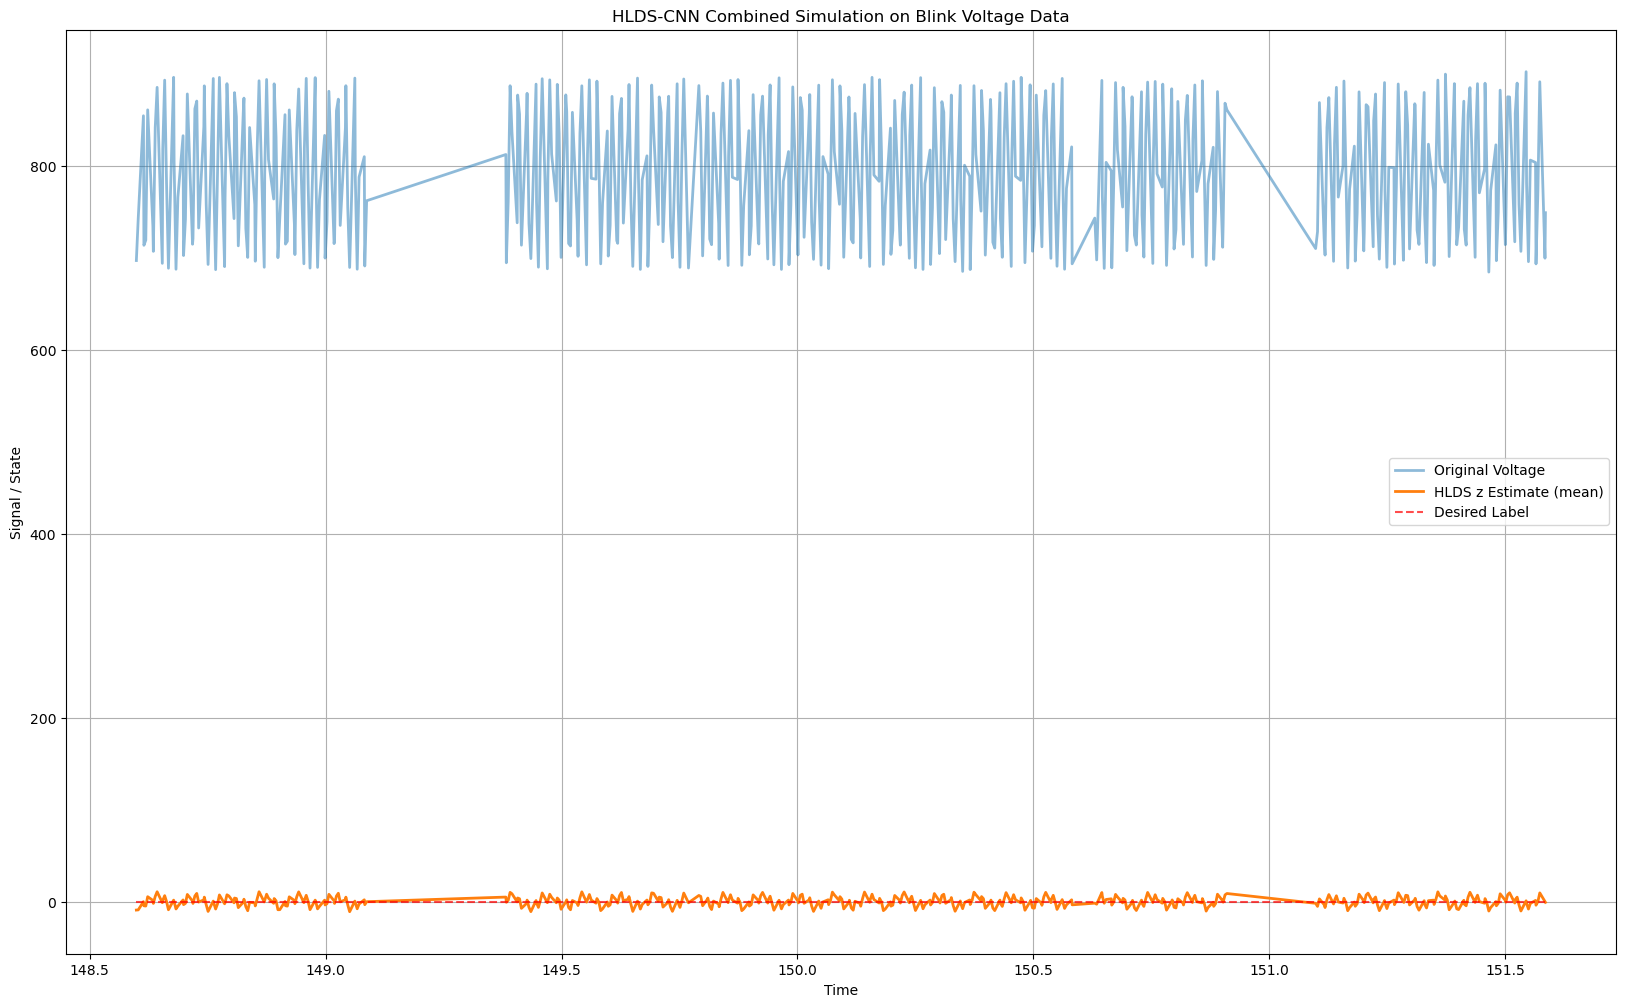

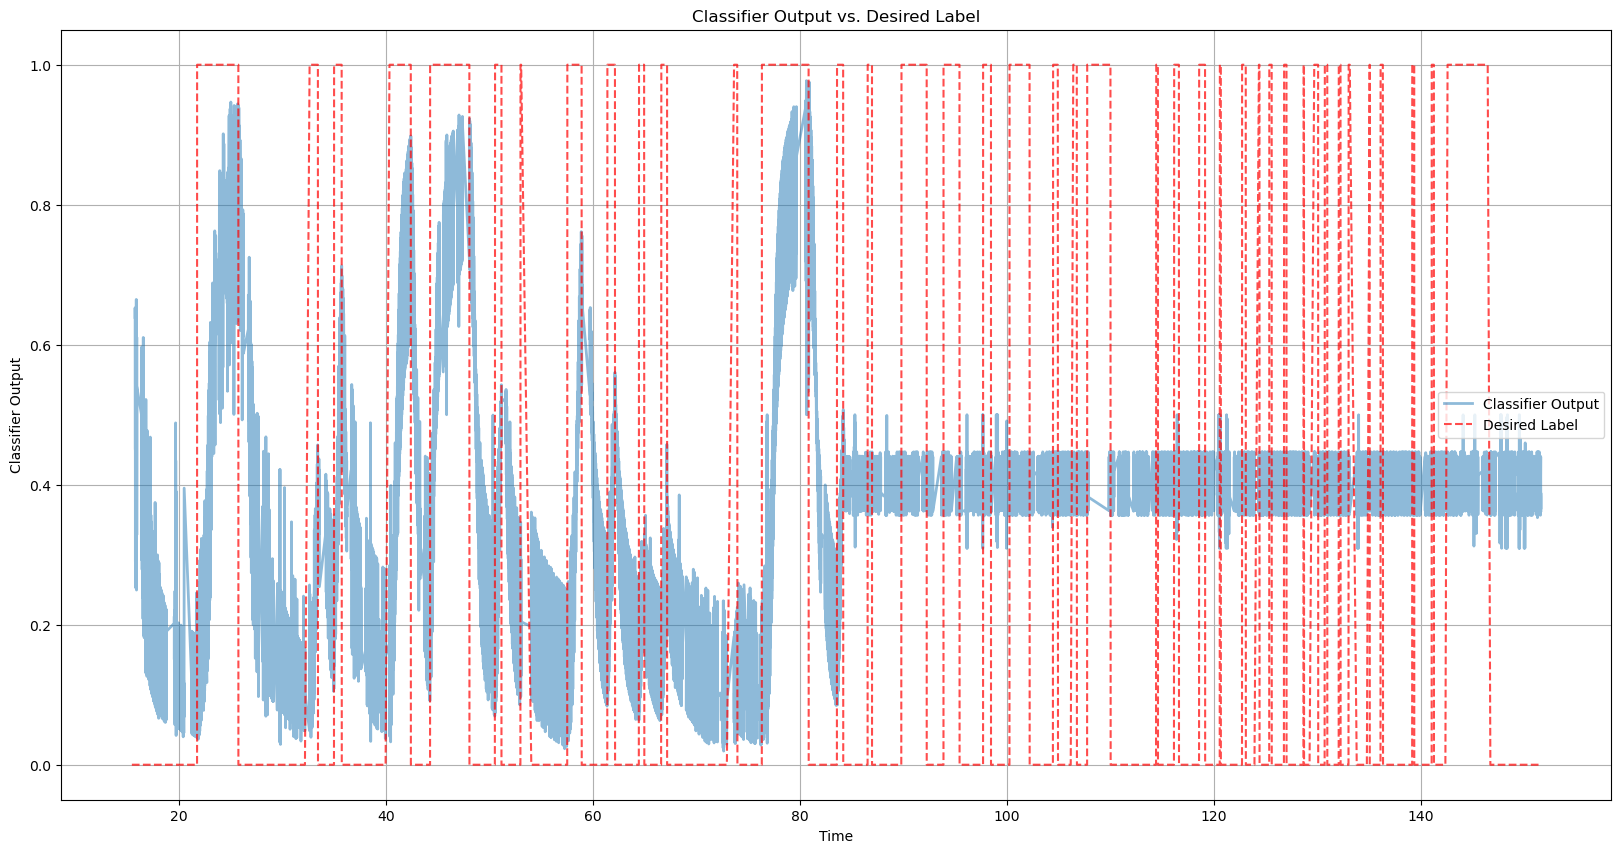

In [24]:
# === Load Data and Prepare Observation Signal ===
data = pd.read_csv('blink3.csv', delimiter=',')
data = data.drop(columns=['Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8'])
voltage = data['Ch1'].to_numpy()      # Voltage measurement (one channel)
time_axis = data['Time'].to_numpy()     # Time vector
desire = data['Label'].to_numpy()       # Desired labels

# Expand voltage to match HLDS measurement dimension.
# Here we assume m = 64.
m = 64
y_signal = np.tile(voltage.reshape(-1, 1), (1, m))  # shape (T, m)

# === Set Up HLDS Parameters ===
s = 4    # Highest layer state (z)
k = 16   # Middle layer state (u)
n = 64   # Lowest layer state (x)
state_dim = s + k + n

# Define dynamics.
F_z = np.eye(s)
G = np.eye(k)
D = 0.1 * np.random.randn(k, s)
F_layer = np.eye(n)
B = 0.1 * np.random.randn(n, k)

# Joint state transition matrix.
F_joint = np.block([
    [F_z,               np.zeros((s, k)),      np.zeros((s, n))],
    [D,                 G,                     np.zeros((k, n))],
    [np.zeros((n, s)),  B,                     F_layer]
])

# Observation matrix (extracts the lowest layer).
H = np.eye(n)  # shape (64, 64)
H_joint = np.hstack([np.zeros((m, s+k)), H])

# Noise covariances.
Q = 0.01 * np.eye(state_dim)
R = 0.5 * np.eye(m)

# Initial HLDS state and covariance.
X_est = np.zeros((state_dim, 1))
P = np.eye(state_dim)

# === Set Up Dual Estimation Variables ===
theta = np.array([[1.0]])
P_theta = np.eye(1)
# phi_func extracts a regressor from the HLDS state.
phi_func = lambda X: np.array([[np.mean(X[s+k:s+k+n])]])

# === Set Up CNN Parameters and Weights ===
M = 64           # Sliding window length (number of taps)
h = 4            # Hidden layer size
input_dim = M * s
w1 = np.random.randn(h, input_dim) / np.sqrt(input_dim)
w2 = np.random.randn(1, h) / np.sqrt(h)
learning_rate = 0.1

# === Run the Combined HLDS-CNN Simulation ===
# Specify the cutoff iteration index (for switching from CNN training to inference).
cutoff = 11000  # Adjust based on your data length and desired training phase

final_X_est, final_P, final_theta, final_P_theta, cnn_outputs, z_estimates = simulation_hlds_cnn_pipeline(
    y_signal, desire, cutoff,
    X_est, P, F_joint, Q, H_joint, R,
    theta, P_theta, phi_func, w1, w2, learning_rate, M, s
)

# === Plot HLDS (z Estimate) vs. Original Voltage and Desired Label ===
# Here we use the mean value of the HLDS z estimates (each of dimension s) as a representative signal.
z_estimates = np.array(z_estimates)  # shape (T+1, s)
z_mean = np.mean(z_estimates, axis=1)

plt.figure(figsize=(20,12))
plt.plot(time_axis[-500:], voltage[-500:], label='Original Voltage', alpha=0.5, linewidth=2)
plt.plot(time_axis[-500:], z_mean[-500:], label='HLDS z Estimate (mean)', linewidth=2)
plt.plot(time_axis[-500:], desire[-500:], label='Desired Label', linestyle='--', color='red', alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Signal / State")
plt.title("HLDS-CNN Combined Simulation on Blink Voltage Data")
plt.legend()
plt.grid(True)
plt.show()

# === Plot the CNN Classifier Output vs. the Desired Label ===
plt.figure(figsize=(20, 10))
plt.plot(time_axis, cnn_outputs, label='Classifier Output', alpha=0.5, linewidth=2)
plt.plot(time_axis, desire, label='Desired Label', linestyle='--', color='red', alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Classifier Output")
plt.title("Classifier Output vs. Desired Label")
plt.legend()
plt.grid(True)
plt.show()

#### Testing Old

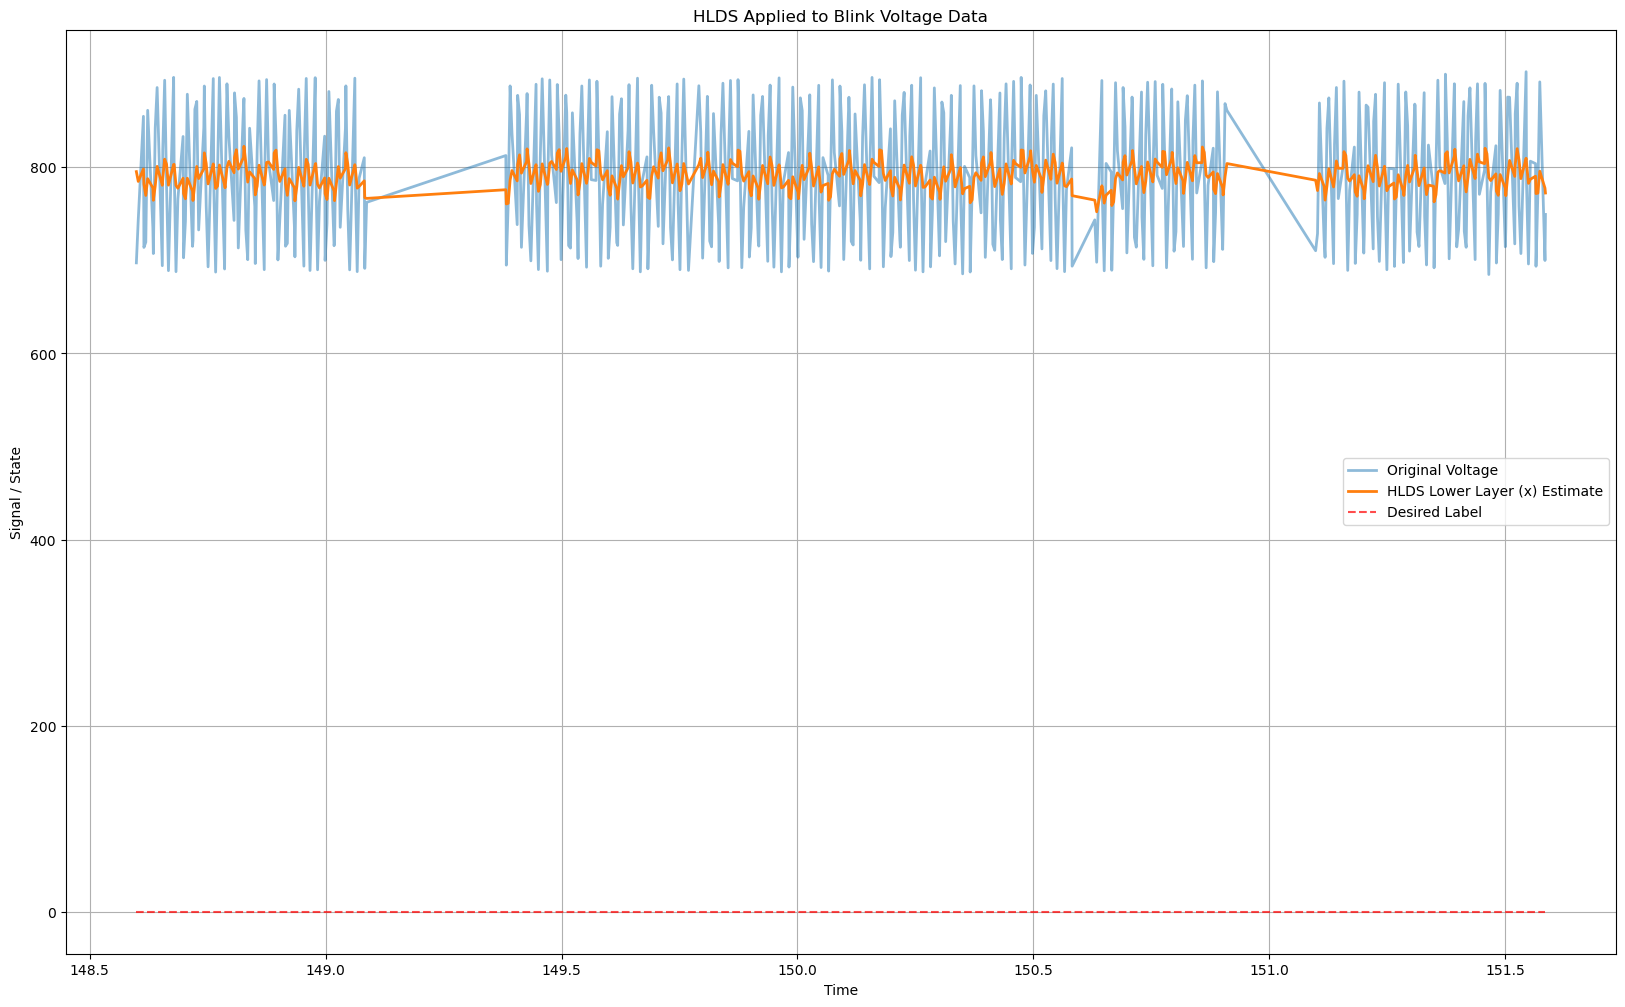

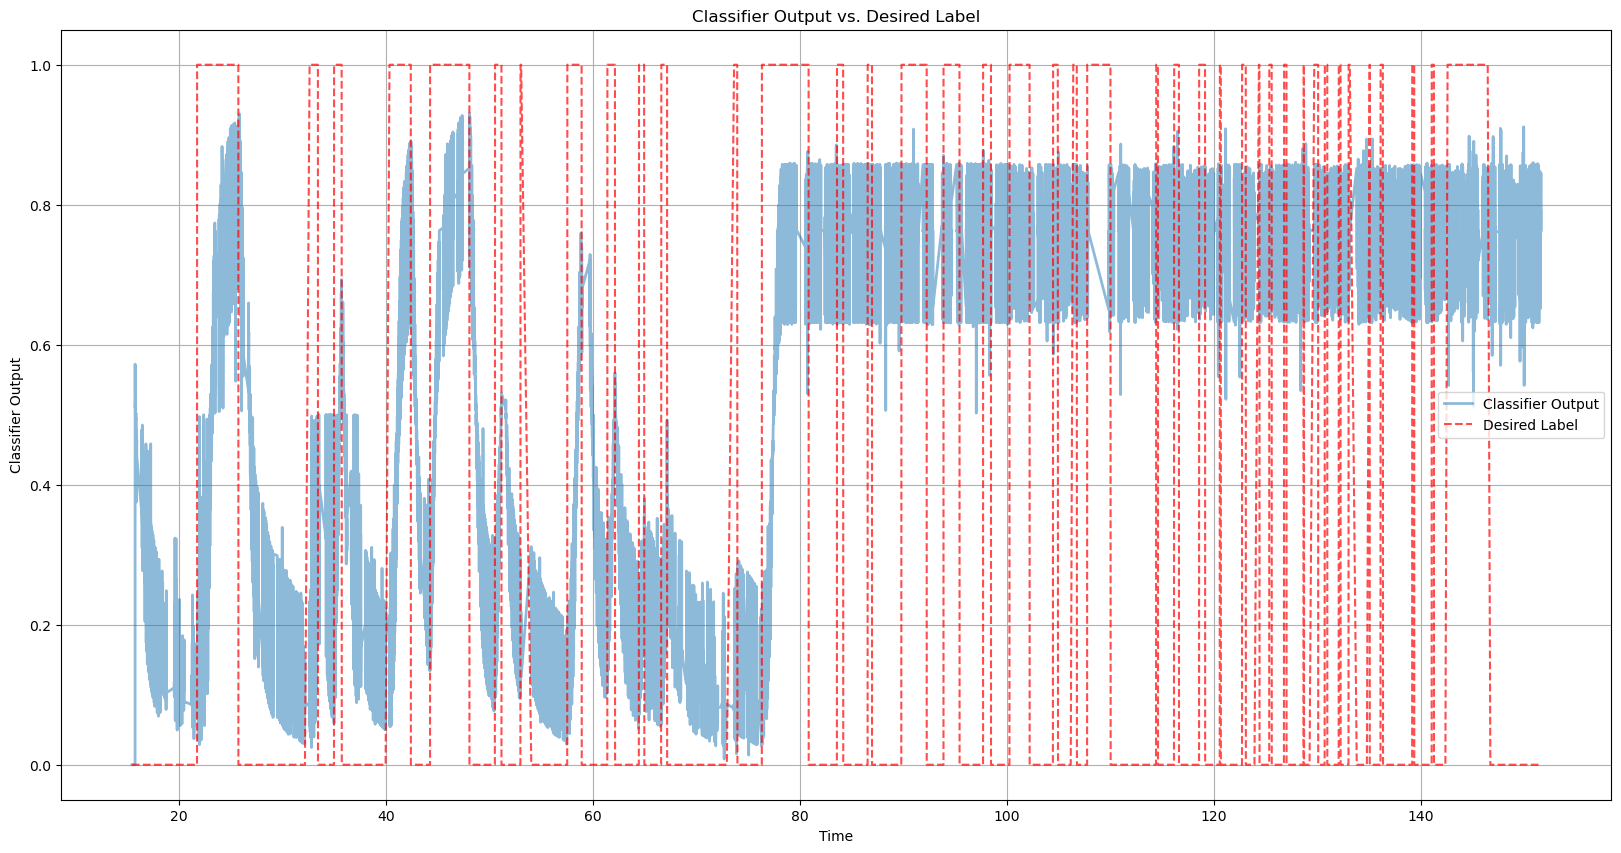

In [26]:
# ============================================================
# Load Data and Prepare Observation Signal
# ============================================================

# Option 1: Load the CSV data.
data = pd.read_csv('blink3.csv', delimiter=',')

# Drop unused channels (Ch2 through Ch8).
data = data.drop(columns=['Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8'])

# Extract data arrays.
voltage = data['Ch1'].to_numpy()      # Voltage measurement (one channel)
time_axis = data['Time'].to_numpy()     # Time vector
desire = data['Label'].to_numpy()       # Desired labels (e.g., blink or no blink)

# Expand voltage to match HLDS measurement dimension.
# Here we assume m = 64 (as set below), so we tile the 1D voltage.
m = 64
y_signal = np.tile(voltage.reshape(-1, 1), (1, m))

# ============================================================
# Set Up HLDS Parameters
# ============================================================

# Dimensions.
s = 4    # Highest layer state (z)
k = 16   # Middle layer state (u)
n = 64   # Lowest layer state (x)
state_dim = s + k + n  # Joint state dimension

# Highest layer dynamics: z_t = z_{t-1} + noise.
F_z = np.eye(s)

# Middle layer dynamics: u_t = G * u_{t-1} + D * z_{t-1} + noise.
G = np.eye(k)
D = 0.1 * np.random.randn(k, s)

# Lower layer dynamics: x_t = F_layer * x_{t-1} + B * u_{t-1} + noise.
F_layer = np.eye(n)
B = 0.1 * np.random.randn(n, k)

# Build the joint state transition matrix:
F_joint = np.block([
    [F_z,              np.zeros((s, k)),       np.zeros((s, n))],
    [D,                G,                      np.zeros((k, n))],
    [np.zeros((n, s)), B,                      F_layer]
])

# Observation: we assume y = x + noise.
# Let H map the lowest-layer state to the measurement.
# Since n = 64 and m = 64, we define H as the identity matrix.
H = np.eye(n)  # shape (64, 64)
# The joint observation matrix extracts the lowest layer.
H_joint = np.hstack([np.zeros((m, s+k)), H])

# Process noise covariance for the joint state.
Q = 0.01 * np.eye(state_dim)
# Measurement noise covariance.
R = 0.5 * np.eye(m)

# Initial joint state estimate and covariance.
X_est = np.zeros((state_dim, 1))
P = np.eye(state_dim)

# ============================================================
# Set Up Dual Estimation (Parameter Learning) Variables
# ============================================================

# For illustration we learn a single parameter (theta) as a scalar.
theta = np.array([[1.0]])   # initial parameter (1x1)
P_theta = np.eye(1)         # initial parameter covariance

# Define phi_func: here we use the average value of the lowest-layer state as the regressor.
# X_est has shape (s+k+n, 1). The lowest layer is the last n rows.
phi_func = lambda X: np.array([[np.mean(X[s+k:s+k+n])]])

# ============================================================
# Run the HLDS Simulation on the Voltage Data
# ============================================================

z_estimates, u_estimates, x_estimates, theta_history = simulation_hlds(
    y_signal, X_est, P, F_joint, Q, H_joint, R, s, k, n, theta, P_theta, phi_func
)

# ============================================================
# Plot the HLDS Output vs. the Original Voltage and Label
# ============================================================

plt.figure(figsize=(20,12))
# For clarity, plot the last 500 data points.
# We plot the original voltage (from one channel), the HLDS lower-layer estimate,
# and the desired label.
plt.plot(time_axis[-500:], voltage[-500:], label='Original Voltage', alpha=0.5, linewidth=2)
# The HLDS lower-layer (x) estimates have dimension 64.
# We use the mean value over the 64 dimensions as a representative signal.
plt.plot(time_axis[-500:], np.mean(x_estimates, axis=1)[-500:], label='HLDS Lower Layer (x) Estimate', linewidth=2)
plt.plot(time_axis[-500:], desire[-500:], label='Desired Label', linestyle='--', color='red', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Signal / State")
plt.title("HLDS Applied to Blink Voltage Data")
plt.legend()
plt.grid(True)
plt.show()

#y2_pred2 = simulation_cnn_inference(z_estimates, w1_final, w2_final, M, s)
# Initialize the CNN weights for the second simulation.
w1_final = np.random.randn(h, M * s) / np.sqrt(M * s)
w2_final = np.random.randn(1, h) / np.sqrt(h)
learning_rate = 0.1
y2_pred2, w1_final, w2_final = simulation_cnn(z_estimates, desire, w1_final, w2_final, learning_rate, M, s, 10000)

# -------------------------------
# Plot the Classifier Output vs. the Desired Label
# -------------------------------
plt.figure(figsize=(20, 10))
# For indices before M, no prediction was computed (they remain zero).
plt.plot(time_axis, y2_pred2.flatten(), label='Classifier Output', alpha=0.5, linewidth=2)
plt.plot(time_axis, desire, label='Desired Label', linestyle='--', color='red', alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Classifier Output")
plt.title("Classifier Output vs. Desired Label")
plt.legend()
plt.grid(True)
plt.show()
